# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [ ]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
#def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
def download(filename, source='https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)


In [91]:
## new download to get data from my repo
def download(filename):
    url = 'https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/raw/main'
    file_url = f'{url}/{filename}'
    cmd = f'wget -O {filename} {file_url}'
    os.system(cmd)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data


Now load in the training set and test set

In [48]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

--2025-04-12 22:04:33--  https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/raw/main/train-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/0tv0renakniga/dsc_255_hw3_minst_data/main/train-images-idx3-ubyte.gz [following]
--2025-04-12 22:04:34--  https://raw.githubusercontent.com/0tv0renakniga/dsc_255_hw3_minst_data/main/train-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

     0K .......... .......... .......... .......... ..........  0% 1.86M 5s
    50K .......... ..

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [49]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

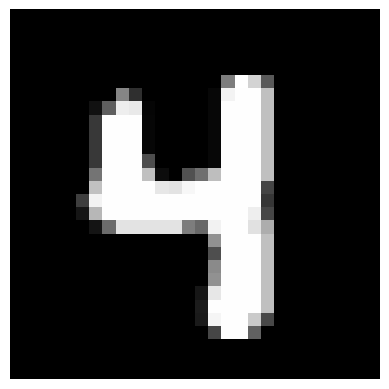

In [50]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [51]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [62]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ## calc priors, means, and covariances
    for j in range(k):
        indices = (y==j).flatten()
        x_j = x[indices]
        pi[j] = x_j.shape[0]/x.shape[0]
        mu[j] = np.mean(x_j, axis=0)
        sigma[j] = np.cov(x_j.T)
    # Halt and return parameters
    return mu, sigma, pi

In [ ]:
def fit_generative_model(x, y):
    """
    Fit a Gaussian generative model to the data with optimized performance.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Training data of shape (n_samples, n_features)
    y : numpy.ndarray
        Training labels of shape (n_samples,)
        
    Returns:
    --------
    mu : numpy.ndarray
        Mean vectors for each class, shape (k, d)
    sigma : numpy.ndarray
        Covariance matrices for each class, shape (k, d, d)
    pi : numpy.ndarray
        Prior probabilities for each class, shape (k,)
    """
    k = 10  # labels 0,1,...,k-1
    d = x.shape[1]  # number of features (784 for MNIST)
    n = x.shape[0]  # number of samples
    
    # Initialize parameters
    mu = np.zeros((k, d))
    sigma = np.zeros((k, d, d))
    pi = np.zeros(k)

    #### you code here
    """
    ------------------------------------------------------------
    STEP 1: calc pi, mu sigma
    ------------------------------------------------------------
    loop over all unique labels 0,1,...,9(i.e n to k-1)
    calc indexes where label is equal to the unique label
    calc pi(class prob) for every unique label
    calc mu(mean vector) for every unique label
    calc sigma(covariance) for every unique labels
        *transform since we want to row to rep features
        *note: this is empirical covariance
    * note: this code return correct dimensions
    ------------------------------------------------------------
    """
    for j in range(k):
        index =  (y==j).flatten()
        pi[j] = np.mean(j==y)
        mu[j] = np.mean(x[index], axis=0)
        sigma[j] = np.cov(x[index].T)

    """
    ------------------------------------------------------------
    STEP 2: find best c for training data
    ------------------------------------------------------------
    initialize values for c to test(c_values)
    Maybe:: split training data(x,y) 80/20 
        * do this since we don't want to overtrain and optimize 
        our c for just the training data
    evaluate performance of each c_val in c_values
    select c_val where errors are minimized

    thought process:
    fit to this such that our prediction given a sample is a 
    specific label moreover, we call this:
                \delta_k(x)=argmax_k p(x|k)p(k)
    or where \delta_k(x) is the maximum will return the predicted class label

    define \delta_k(x) as*:
    \delta_k(x) = x^T *\Sigma_k^{-1}*\mu_k - 0.5*(\mu_k^T)*\Sigma_k^{-1}*\mu_k + \log(\pi_k))
    -pi_k is the prior probability of class k(i.e. label frequency)
    -x is the sample
    -\mu_k is the mean vector for class k(i.e. what does the average sample look like for each label)
    -sigma_k is the covariance matrix for class k(i.e. how do the samples vary around the mean)
    -w^T is the transform of a vector w
    -np.log is the natural log

    *pg.151 {book name} eq'n: 4.24
    ------------------------------------------------------------
    """


    ## initialize c values to test
    c_values = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    
    ## find best c
    best_c = find_best_regularization(k,d,x,y,c_values)

    ## regularize sigma
    for j in range(k):
        sigma[j] = sigma[j] + best_c*np.eye(d)

    return(mu,sigma,pi)

def find_best_regularization(k,d,x,y,c_values):
    ## import train_test_split and accuracy_score from sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    ## initialize train/test(80/20) to evaluate best c 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

    ## initialize best c
    best_c = None
    best_accuracy = 0

    ## initialize mu,sigma,pi, and I to iterate over c_values
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    I = np.eye(d)

    ## initialize y_pred
    y_pred = np.zeros(X_test.shape[0])

    ## loop over c_values
    for c_val in c_values:
        ## calc sigma,mu,pi
        ## note sigma is regularized covariance matrix now
        for j in range(k):
            index =  (y_train==j).flatten()
            pi[j] = np.mean(j==y_train)
            mu[j] = np.mean(X_train[index], axis=0)
            sigma[j] = np.cov(X_train[index].T)+ c_val*I
        
        ## calc prediction
        for i in range(X_test.shape[0]):
            max_val = -np.inf
            for j in range(k):
                # classifiy each prediction using \delta_k(x) expression
                delta_k = np.dot(X_test[i], np.linalg.inv(sigma[j])).dot(mu[j]) - 0.5*(mu[j].T).dot(np.linalg.inv(sigma[j])).dot(mu[j]) + np.log(pi[j])
                if delta_k > max_val:
                    max_val = delta_k
                    y_pred[i] = j

        ## calc accuracy
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c = c_val
    print(f"Best c value: {best_c} with accuracy: {best_accuracy}")
    return(best_c)


<>:51: SyntaxWarning: invalid escape sequence '\d'
<>:51: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_231802/3643532327.py:51: SyntaxWarning: invalid escape sequence '\d'
  """


Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

In [112]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)

displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

/tmp/ipykernel_231802/3643532327.py:51: SyntaxWarning: invalid escape sequence '\d'
  """


KeyboardInterrupt: 

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [ ]:
k=10
# Compute log Pr(label|image) for each [test image,label] pair.
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 806 errors out of 10000


label is 5
training data is:
(784,)
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0 
  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0 
  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0 
  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 

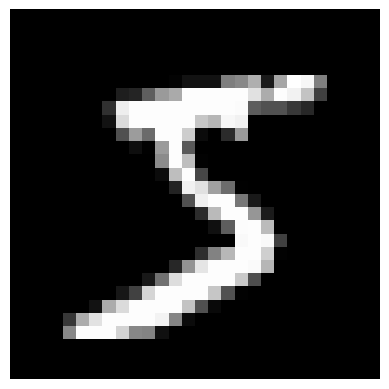

In [106]:
print(f'label is {train_labels[0]}')
print(f'training data is:')
print(train_data[0,:].shape)
rs = train_data[0,:].reshape(28,28)
for i in range(28):
    for j in range(28):
        #print(rs[i,j], end=' ')
        if len(str(rs[i,j])) == 1:
            w = '  ' + str(rs[i,j])
            print(w, end=' ')
        elif len(str(rs[i,j])) == 2:
            w = ' ' + str(rs[i,j])
            print(w, end=' ')
        else:
            print(str(rs[i,j]), end=' ')
    print()
displaychar(train_data[0])


## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?



<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?